In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set(style='whitegrid')


In [5]:
# Load the Brent oil prices CSV
df = pd.read_csv("../data/BrentOilPrices.csv")

# Display the first 5 rows
df.head()


,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [6]:
# Check the column names, non-null counts, and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


In [7]:
# Summary statistics
df.describe()


,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


In [13]:
df = pd.read_csv("../data/BrentOilPrices.csv")
print(df.head())

df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
print(df[df['Date'].isna()])  # Check if any dates failed parsing

df.set_index('Date', inplace=True)
print(df.info())
print(df.head())

        Date  Price
0  20-May-87  18.63
1  21-May-87  18.45
2  22-May-87  18.55
3  25-May-87  18.60
4  26-May-87  18.63


C:\Users\HP\AppData\Local\Temp\ipykernel_18976\561180855.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)


Empty DataFrame
Columns: [Date, Price]
Index: []
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9011 entries, 1987-05-20 to 2022-11-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9011 non-null   float64
dtypes: float64(1)
memory usage: 140.8 KB
None
            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63


In [14]:
# Step 1: Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 Price    0
dtype: int64


In [15]:
# Step 2: Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")


Number of duplicate rows: 3996


In [16]:
# Remove duplicate rows
df = df.drop_duplicates()

# Confirm duplicates removed
print(f"Number of rows after removing duplicates: {len(df)}")


Number of rows after removing duplicates: 5015


In [17]:
# Check for non-positive prices (<= 0)
invalid_prices = df[df['Price'] <= 0]

print(f"Number of rows with non-positive prices: {len(invalid_prices)}")


Number of rows with non-positive prices: 0


In [18]:
# Sort dataframe by Date index in ascending order
df = df.sort_index()

# Check first 5 rows after sorting
df.head()


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-29,18.58


In [19]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]

print(f"Number of outliers detected: {len(outliers)}")
outliers.head()


Number of outliers detected: 0


,Price
Date,


In [20]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("The series is stationary (reject H0)")
else:
    print("The series is non-stationary (fail to reject H0)")


ADF Statistic: -2.044065092852691
p-value: 0.2675923567852142
The series is non-stationary (fail to reject H0)


In [21]:
# Apply first order differencing
df_diff = df['Price'].diff().dropna()

# Run ADF test again on differenced series
result_diff = adfuller(df_diff)
print('ADF Statistic (differenced):', result_diff[0])
print('p-value (differenced):', result_diff[1])

if result_diff[1] < 0.05:
    print("Differenced series is stationary (reject H0)")
else:
    print("Differenced series is still non-stationary (fail to reject H0)")


ADF Statistic (differenced): -16.522884417421956
p-value (differenced): 2.0565674416240213e-29
Differenced series is stationary (reject H0)


In [22]:
# Create a complete date range from min to max date
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Find missing dates by comparing with actual dates in df
missing_dates = full_date_range.difference(df.index)

print(f"Number of missing dates: {len(missing_dates)}")
if len(missing_dates) > 0:
    print("Sample missing dates:", missing_dates[:10])
else:
    print("No missing dates found.")


Number of missing dates: 7948
Sample missing dates: DatetimeIndex(['1987-05-23', '1987-05-24', '1987-05-26', '1987-05-27',
               '1987-05-28', '1987-05-30', '1987-05-31', '1987-06-05',
               '1987-06-06', '1987-06-07'],
              dtype='datetime64[ns]', freq=None)


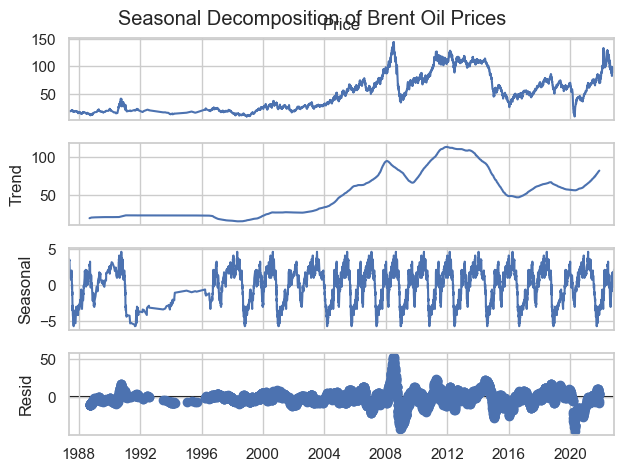

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Use additive model by default; change to multiplicative if data warrants
result = seasonal_decompose(df['Price'], model='additive', period=365)

# Plot the decomposed components
result.plot()
plt.suptitle('Seasonal Decomposition of Brent Oil Prices')
plt.show()


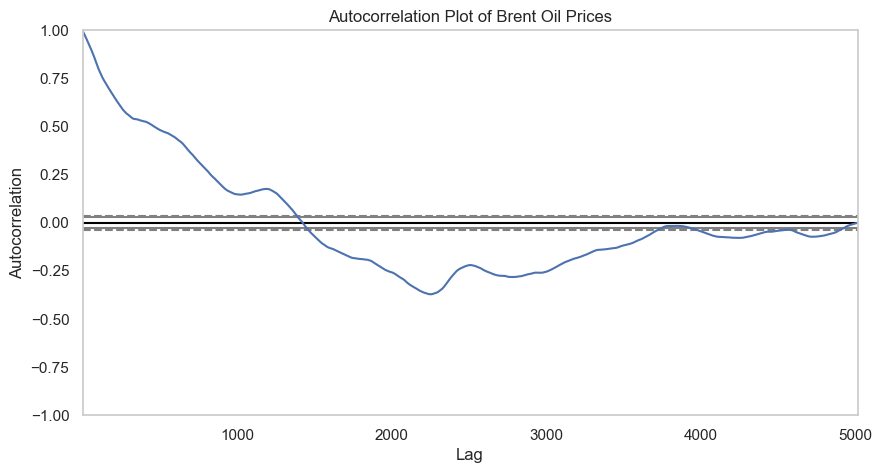

In [24]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 5))
autocorrelation_plot(df['Price'])
plt.title('Autocorrelation Plot of Brent Oil Prices')
plt.show()


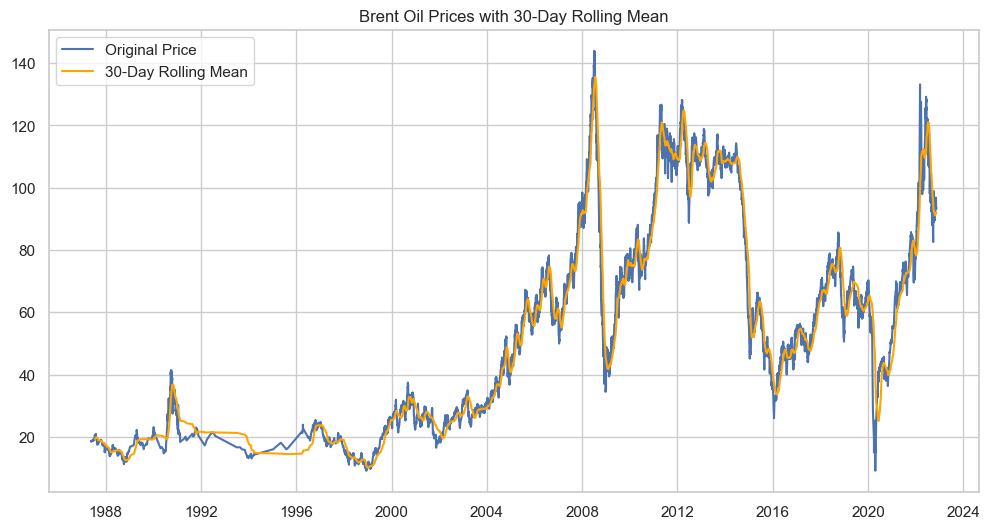

In [25]:
plt.figure(figsize=(12,6))
plt.plot(df['Price'], label='Original Price')
plt.plot(df['Price'].rolling(window=30).mean(), label='30-Day Rolling Mean', color='orange')
plt.title('Brent Oil Prices with 30-Day Rolling Mean')
plt.legend()
plt.show()


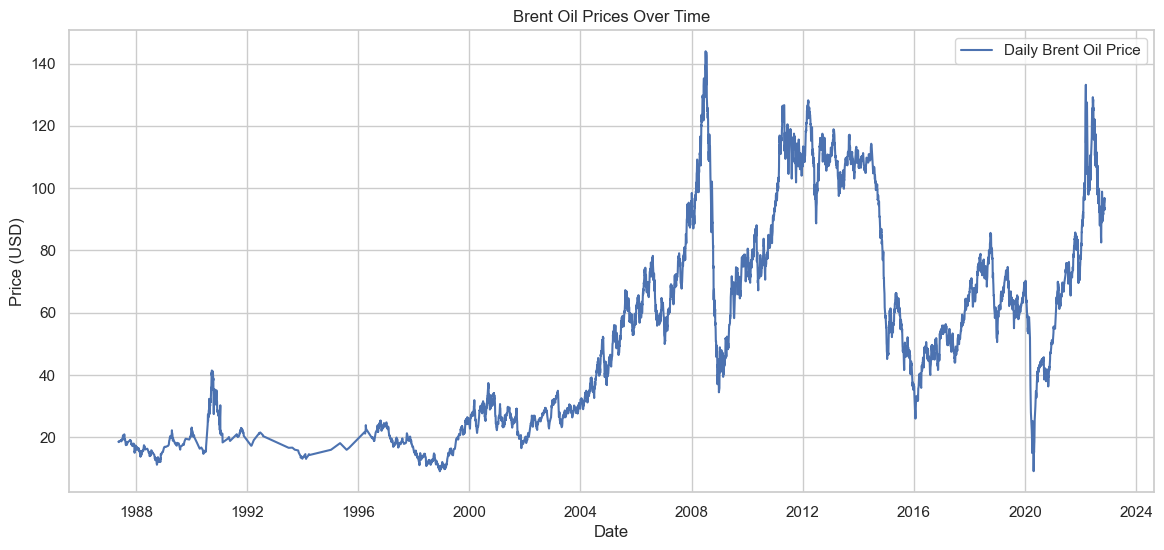

In [26]:
# Cell 1: Line plot of oil prices over time

plt.figure(figsize=(14,6))
plt.plot(df['Price'], label='Daily Brent Oil Price')
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


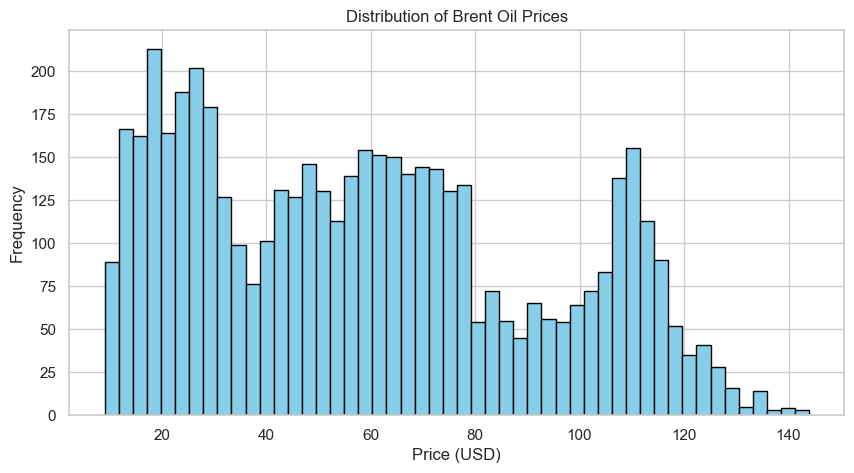

In [27]:
# Cell 2: Histogram to check price distribution

plt.figure(figsize=(10,5))
plt.hist(df['Price'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Brent Oil Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


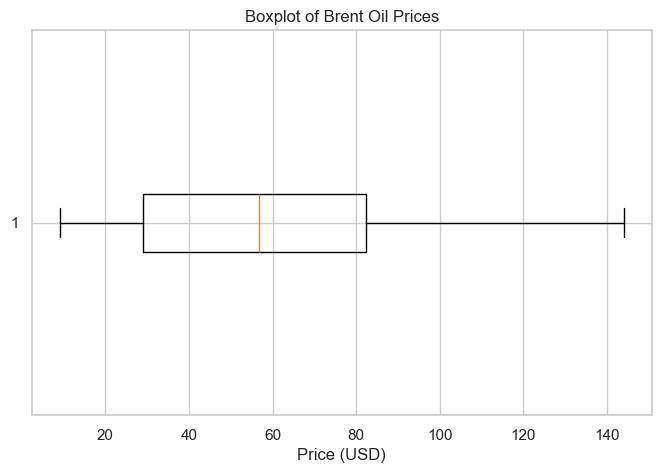

In [28]:
# Cell 3: Boxplot to detect outliers visually

plt.figure(figsize=(8,5))
plt.boxplot(df['Price'], vert=False)
plt.title('Boxplot of Brent Oil Prices')
plt.xlabel('Price (USD)')
plt.grid(True)
plt.show()


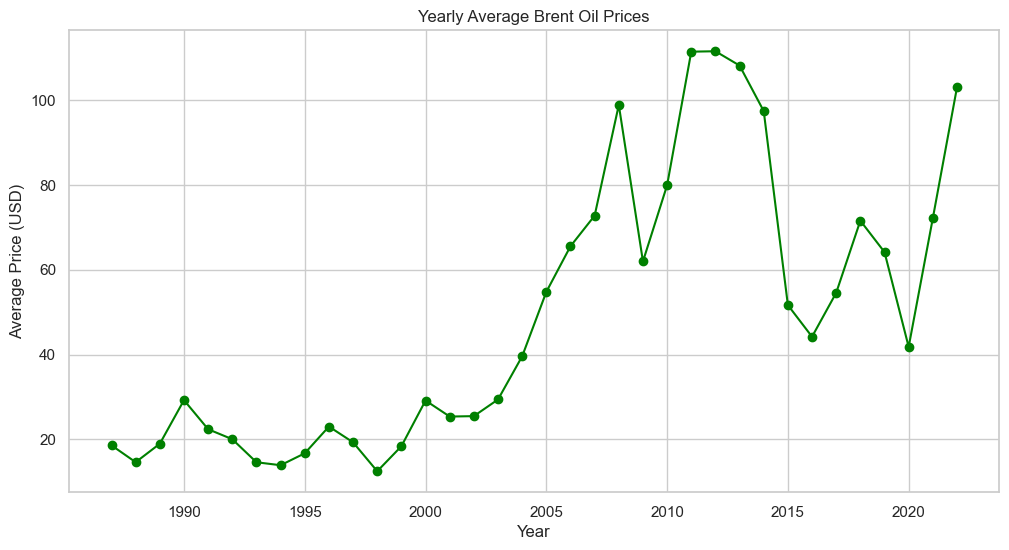

In [29]:
# Cell 4: Yearly average oil price trend (to spot longer-term movement)

df['Year'] = df.index.year
yearly_avg = df.groupby('Year')['Price'].mean()

plt.figure(figsize=(12,6))
plt.plot(yearly_avg.index, yearly_avg.values, marker='o', linestyle='-', color='green')
plt.title('Yearly Average Brent Oil Prices')
plt.xlabel('Year')
plt.ylabel('Average Price (USD)')
plt.grid(True)
plt.show()


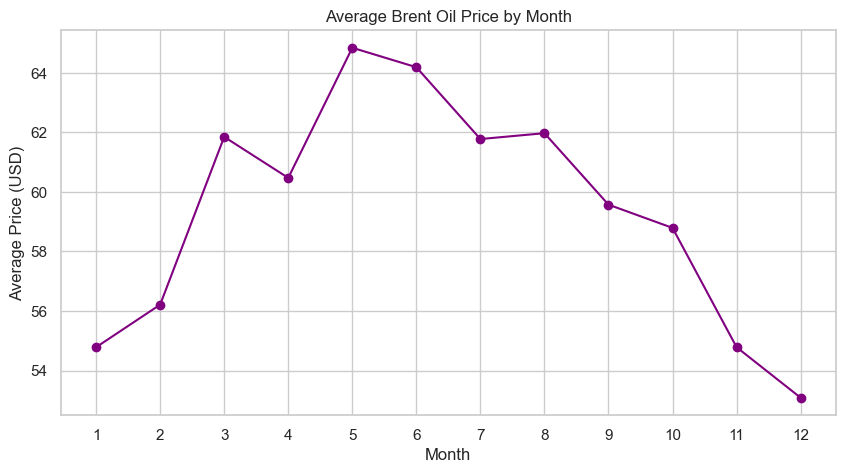

In [30]:
# Cell 5: Monthly seasonality plot

df['Month'] = df.index.month
monthly_avg = df.groupby('Month')['Price'].mean()

plt.figure(figsize=(10,5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-', color='purple')
plt.title('Average Brent Oil Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price (USD)')
plt.xticks(range(1,13))
plt.grid(True)
plt.show()
